In [2]:
import tensorflow as tf
import numpy as np
from scipy.misc import imread
from glob import glob
from matplotlib import pyplot as plt
from TFVision import classification
%matplotlib inline

np.random.seed(42)

### Import and split data

In [3]:
def get_name(filepath):
    return filepath.split('\\')[-1]

n_cracked   = len(glob('./Data/170729_Panel_Solos_Resized/CrackedScores/*.png'))
n_query     = 3

cracked_score_fps   = glob('./Data/170729_Panel_Solos_Resized/CrackedScores/*.png')
uncracked_score_fps = glob('./Data/170729_Panel_Solos_Resized/UncrackedScores/*.png') 

image_filepaths     = (['./Data/170729_Panel_Solos_Resized/Cracked/' + get_name(fp) 
                         for fp in cracked_score_fps] +
                       ['./Data/170729_Panel_Solos_Resized/Uncracked/' + get_name(fp)
                         for fp in uncracked_score_fps])

score_filepaths  = ( cracked_score_fps +
                      uncracked_score_fps )

scores  = np.expand_dims(np.array(
                [imread(fp) for fp in score_filepaths], dtype = 'float32'), axis = -1)
images  = np.expand_dims(np.array(
                [imread(fp) for fp in image_filepaths], dtype = 'float32'), axis = -1)

query_ix     = np.random.randint(0, n_cracked, 3)
query_mask   = np.zeros([scores.shape[0]], dtype = bool)
query_mask[query_ix] = True

query_scores = scores[query_mask, :, :, :]
query_images = images[query_mask, :, :, :]
scores       = scores[np.logical_not(query_mask), :, :, :]
images       = images[np.logical_not(query_mask), :, :, :]

labels       = (np.sum(scores, axis = (1, 2)) > 0).squeeze()

print('Images and score masks successfully read.')

Images and score masks successfully read.


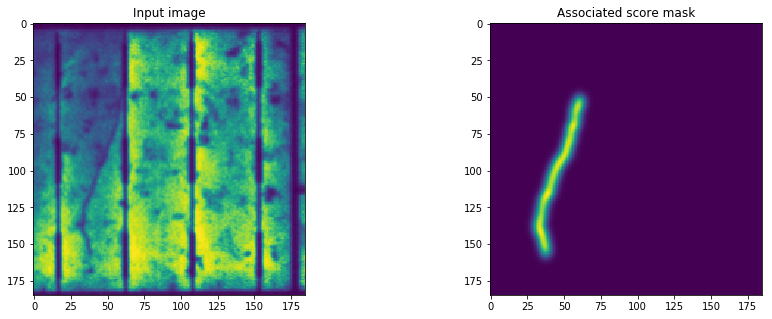

In [4]:
f, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].imshow(query_images[0, :, :, 0]); axs[0].set_title('Input image')
axs[1].imshow(query_scores[0, :, :, 0]); axs[1].set_title('Associated score mask');

### Define TensorFlow graph

In [5]:
TF = {
    'batch_size' : 16,
    'image_size' : 185,
    'filter_size' : [20],
    'in_channels' : 1,
    'out_channels' : [32],
    'learning_rate' : 0.001,
    'training_steps' : 500
}

In [6]:
class BatchNormalizedConvLayer(object):
    def __init__(self, map_size, in_channels, out_channels, activate=True):
        self.filters    = tf.Variable(tf.truncated_normal(
                                        shape = [map_size, map_size, in_channels, out_channels],
                                        stddev = 0.001))
        self.biases     = tf.Variable(tf.zeros(shape = [out_channels]))
        self.input_mean = tf.Variable(tf.zeros(shape = [out_channels]), trainable = False)
        self.input_var  = tf.Variable(tf.zeros(shape = [out_channels]), trainable = False)
        self.decay      = 0.99
        self.activate   = activate

    def training(self, data_in):
        self.conv        = tf.nn.conv2d(data_in, self.filters, strides = [1, 1, 1, 1],
                                       padding = 'SAME', use_cudnn_on_gpu = True)
        mu, var          = tf.nn.moments(self.conv, axes = [0, 1, 2], keep_dims = False)
        self.update_mean = tf.assign(self.input_mean, self.decay*(self.input_mean)
                                                      + (1 - self.decay)*mu)
        self.update_var  = tf.assign(self.input_var,  self.decay*(self.input_var)
                                                      + (1 - self.decay)*var)

        with tf.control_dependencies([self.update_mean, self.update_var]):
            self.norm_conv  = tf.nn.batch_normalization(self.conv, mean = mu,
                                                        variance = var, offset = None,
                                                        scale = None, variance_epsilon = 1e-5)
        if self.activate:
            return tf.nn.relu(self.norm_conv + self.biases)
        else:
            return self.norm_conv + self.biases

    def testing(self, data_in):
        self.conv       = tf.nn.conv2d(data_in, self.filters, strides = [1, 1, 1, 1],
                                       padding = 'SAME', use_cudnn_on_gpu = True)
        mu, var         = tf.nn.moments(self.conv, axes = [0, 1, 2], keep_dims = False)
        self.norm_conv  = tf.nn.batch_normalization(self.conv, mean = self.input_mean,
                                                    variance = self.input_var, offset = None,
                                                    scale = None, variance_epsilon = 1e-5)
        if self.activate:
            return tf.nn.relu(self.norm_conv + self.biases)
        else:
            return self.norm_conv + self.biases

In [7]:
graph = tf.Graph()

with graph.as_default():
    with tf.name_scope('Inputs'):
        TF['data']   = tf.placeholder(tf.float32,
                                      shape = [None, TF['image_size'],
                                               TF['image_size'], TF['in_channels']])
        TF['scores'] = tf.placeholder(tf.float32,
                                      shape = [None, TF['image_size'],
                                               TF['image_size'], 1])
    
    with tf.name_scope('ConvolutionalLayers'):
        # First layer is 32 20x20 convolutions, with an activation
        ConvLayer1 = BatchNormalizedConvLayer(TF['filter_size'][0], TF['in_channels'],
                                              TF['out_channels'][0], activate = True)

        # Perform 2 1x1 convolutions (no nonlinearity) to produce a 2-channel image
        ConvLayer2 = BatchNormalizedConvLayer(1, TF['out_channels'][0],
                                              2, activate = False)
    

    def training_model(data):
        activation1 = ConvLayer1.training(data)
        logits      = ConvLayer2.training(activation1)
        return logits
        
    def testing_model(data):
        activation1 = ConvLayer1.testing(data)
        logits      = ConvLayer2.testing(activation1)
        return logits
    
    with tf.name_scope('Training'):
        logits                     = training_model(TF['data'])
        TF['training_predictions'] = tf.nn.softmax(logits, dim = -1)
        TF['training_loss']        = tf.reduce_mean(tf.square(
                                        TF['training_predictions'] - TF['scores'])) # Mean RSS 
        
        with tf.name_scope('Gradients'):
            optimizer      = tf.train.GradientDescentOptimizer(TF['learning_rate'])
            vars_to_update = [ConvLayer1.filters, ConvLayer2.filters,
                              ConvLayer1.biases, ConvLayer2.biases]
            gradients      = optimizer.compute_gradients(TF['training_loss'],
                                                         vars_to_update)
            TF['optimize'] = optimizer.apply_gradients(gradients)
        
    with tf.name_scope('Testing'):
        logits = testing_model(TF['data'])
        TF['testing_predictions'] = tf.nn.softmax(logits, dim = -1)
        TF['testing_loss']        = tf.square(TF['testing_predictions'] - TF['scores'])
        
    TF['saver'] = tf.train.Saver()

### Instantiate and train the model

In [8]:
def augment_images(images, scores):
    """
        Applies augmentations to a minibatch.
        > Flips
        > Whitens
    """
    # Flip images lr
    flip_lr = np.random.randint(0, 2, images.shape[0])
    images[flip_lr, :, :, :] = np.flip(images[flip_lr, :, :, :], axis = 2)
    scores[flip_lr, :, :, :] = np.flip(scores[flip_lr, :, :, :], axis = 2)
    
    # Flip images ud
    flip_ud = np.random.randint(0, 2, images.shape[0])
    images[flip_ud, :, :, :] = np.flip(images[flip_ud, :, :, :], axis = 1)
    scores[flip_ud, :, :, :] = np.flip(scores[flip_ud, :, :, :], axis = 1)
    
    # Whiten across minibatch; this has a regularizing effect
    images = (images - np.mean(images, axis = 0))/images.std(axis = 0)
    
    return images, scores

In [13]:
def get_minibatch(batch_size, images, scores, labels):
    """
        Returns a balanced and augmented subset of the images and scores passed.
    
        Labels is a binary mask indicating which images contain cracks
        Images is a stack of images, ordered in the same sequence as scores
        Scores is a stack of np.float32 masks of crack scores, ordered in the same sequence as images
    """
    ix = {
          'cracked'   : np.array(np.nonzero(labels)).squeeze(),
          'uncracked' : np.array(np.nonzero(np.logical_not(labels))).squeeze()
         }
    ix['cracked']    = np.random.choice(ix['cracked'],
                                     size = batch_size // 2, replace = True)
    ix['uncracked']  = np.random.choice(ix['uncracked'],
                                       size = batch_size // 2, replace = True)
    ix               = list(ix['cracked']) + list(ix['uncracked'])

    minibatch_images, minibatch_scores = augment_images(images[ix, :, :, :],
                                                        scores[ix, :, :, :])
    return minibatch_images, minibatch_scores

In [14]:
with tf.Session(graph = graph) as session:
    session.run(tf.global_variables_initializer())
    
    for step in range(TF['training_steps']):
        minibatch_images, minibatch_scores = get_minibatch(TF['batch_size'],
                                                           images, scores, labels)
        fd = { TF['data']   : minibatch_images,
               TF['scores'] : minibatch_scores }
        _, l = session.run([TF['optimize'], TF['training_loss']], feed_dict = fd)
        
        if step % 100 == 0:
            print('Minibatch RSS @ step {}: {}'.format(step, l))

Minibatch RSS @ step 0: 534.3377075195312


KeyboardInterrupt: 